In [18]:
import re
import requests
from nltk import Tree


def parser(expression):
    old = expression.replace(' ', '_').replace('>_(', '> (').replace(')_(', ') (').replace(')_)', ') )').replace(')_)', ') )').replace(' (', '(')
    new = ''
    for x in range(0, len(old) - 1):
        if old[x] == '(' and old[x+1].isalpha():
            new += '{'
        elif old[x] == ')' and (old[x-1].isalpha() or old[x-1] == ']'):
            new += '}'
        else:
            new += old[x]
    new += old[len(old)-1]
    return new

In [2]:
from pycorenlp import StanfordCoreNLP
import json

nlp = StanfordCoreNLP('http://localhost:9000')
dependency_parser = nlp.annotate

def pos_tag(sentence):
    result = dependency_parser(sentence, properties={"outputFormat": "json", "annotators": "pos"})['sentences'][0]['tokens']
    res = []
    for pos in result:
        res.append(pos['pos'])
    return res

In [3]:
def insert_pos_tag(exp, pos):
    count = 0
    res = ''
    for x in range(0, len(exp)):
        if exp[x] == 'S' and exp[x+1]==' ' and exp[x+2] == 'P':
            res += 'S '
            res += pos[count]
            count += 1
            x += 4
        else:
            res += exp[x]
    return res

In [4]:
def direction(exp):
    cont = False
    for x in exp:
        if x == '{':
            cont = True
        elif x == '}':
            cont = False
            continue
        if cont == True:
            continue
        if x == '/':
            return '/'
        elif x == '\\':
            return '\\'
    return False

In [5]:
import nltk
from nltk.sem.logic import *

read_expr = nltk.sem.Expression.fromstring

def lambda_calculus(tree):
    tree_string = str(tree)
    
    if tree_string[2] == 'L':
        pos = tree_string.split('_')[3]
        word = tree_string.split('_')[5]
        
        #                        #
        # masukin rulenya disini #
        #                        #
        if pos == 'NN':
            return read_expr(r'(' + word + ')')
        elif pos == 'VBD':
            return read_expr(r'\X \Y.' + word + '(X, Y)')
        else:
            return read_expr(r'\X.X')
    
    # ini cuma masukin ke array
    sub = []
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            sub.append(subtree)
            
    # urutan operasi lambda calculusnya
    first = sub[0]
    second = sub[1]
    notation = str(sub[1]).split('_')[1]
    if direction(notation) == '\\':
        first = sub[1]
        second = sub[0]
    
    # rekursi
    return ApplicationExpression(lambda_calculus(first), lambda_calculus(second)).simplify()

In [7]:
from_res = '(<T S[dcl] 0 2> (<T NP 0 2> (<L NP[nb]/N POS POS the NP[nb]/N>) (<L N POS POS hotel N>) ) (<T S[dcl]\\NP 0 2> (<L (S[dcl]\\NP)/NP POS POS had (S[dcl]\\NP)/NP>) (<T NP 0 2> (<L NP[nb]/N POS POS an NP[nb]/N>) (<T N 0 2> (<L N/N POS POS exceptional N/N>) (<L N POS POS service N>) ) ) ) )'
pos_tagged = insert_pos_tag(from_res, pos_tag('the hotel had a exceptional service'))

hasil = parser(pos_tagged)

from nltk import Tree
tree = Tree.fromstring(hasil)
# t.pretty_print()

In [8]:
lambda_calculus(tree)

<ApplicationExpression had(service,hotel)>

In [9]:
hasil

'(<T_S[dcl]_0_2>(<T_NP_0_2>(<L_NP[nb]/N_POS_DT_POS_the_NP[nb]/N>)(<L_N_POS_NN_POS_hotel_N>) )(<T_S[dcl]\\NP_0_2>(<L_{S[dcl]\\NP}/NP_POS_VBD_POS_had_{S[dcl]\\NP}/NP>)(<T_NP_0_2>(<L_NP[nb]/N_POS_DT_POS_an_NP[nb]/N>)(<T_N_0_2>(<L_N/N_POS_JJ_POS_exceptional_N/N>)(<L_N_POS_NN_POS_service_N>) ) ) ) )'

In [10]:
pos_tagged

'(<T S[dcl] 0 2> (<T NP 0 2> (<L NP[nb]/N POS DT POS the NP[nb]/N>) (<L N POS NN POS hotel N>) ) (<T S[dcl]\\NP 0 2> (<L (S[dcl]\\NP)/NP POS VBD POS had (S[dcl]\\NP)/NP>) (<T NP 0 2> (<L NP[nb]/N POS DT POS an NP[nb]/N>) (<T N 0 2> (<L N/N POS JJ POS exceptional N/N>) (<L N POS NN POS service N>) ) ) ) )'

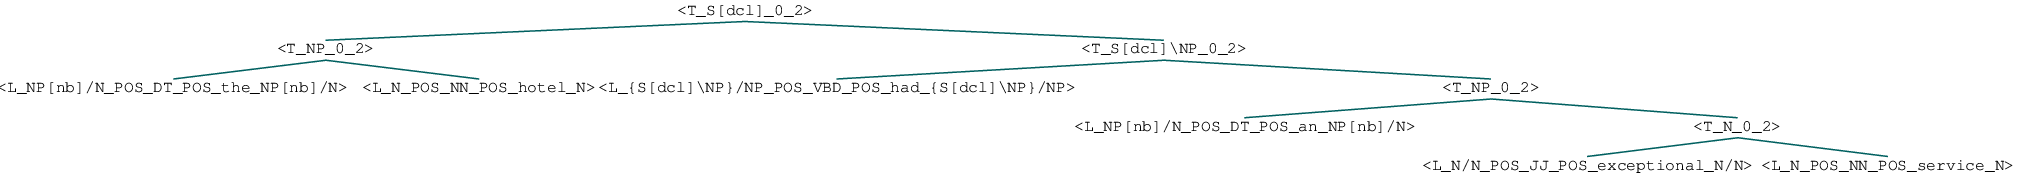

In [11]:
tree

In [20]:
def glue_process(sent):
    url = "http://localhost:5000/ccgParsing"
    data = {"sent": sent}
    r = requests.post(url, data=data)

    res = r.json()
    
    from_res = res['tree']
    pos_tagged = insert_pos_tag(from_res, pos_tag(data['sent']))

    hasil = parser(pos_tagged)

    tree = Tree.fromstring(hasil)
    return lambda_calculus(tree)



In [21]:
glue_process('I bought my canon g3 about a month ago and i have to say i am very satisfied')

<ApplicationExpression month(\Y.bought(canon(g3),Y),\X.X)>